In [31]:
# only run if you add new packages
! pip freeze > requirements.txt

In [4]:
%%capture
! pip install -r requirements.txt

In [59]:
from dotenv import load_dotenv
import openai
import os
import json
import asyncio
import pandas as pd
import matplotlib.pyplot as plt
import datetime

### Assign vars

In [69]:
load_dotenv()
openai.api_key = os.environ.get("AZURE_OPENAI_KEY")
openai.api_type = "azure"
openai.api_base = "https://leftrightleft-azure-open-ai.openai.azure.com/"
openai.api_version = "2023-05-15"
deployment_id = "gpt-35-turbo-16k"
# You can add additional models and temperatures here for comparison
models = ["gpt-35-turbo-16k"]
temperatures = [0.0]
prompt = """
        You are a decision tool responsible for determining whether a static analysis using CodeQL should be performed on a given code diff from a GitHub pull request. Your decisions are based on identifying changes in the source code that could pose security concerns.

        Your criteria for triggering a 'yes' decision are as follows:

        Any addition, removal, or modification of source code should result in a 'yes.'
        Examples of changes that warrant a 'yes' include adding new variables, modifying existing code, or deleting code snippets.
        On the other hand, a 'no' decision should be made if:

        The application's source code remains unaltered.
        Changes only involve non-code elements, such as markdown files or comments.
        Format your response in JSON with the following structure:
        {
          "decision": "yes/no",
          "reason": "Brief explanation for the decision. Keep it to two or three sentences."
        }
        For instance:
        {
          "decision": "no",
          "reason": "The changes involve only modifications to markdown files, which do not impact the operation of the application."
        }
        Ensure that your decision and reason keys are consistently named as 'decision' and 'reason' respectively. Provide clear, concise justifications for your decisions.

        #### START EXAMPLES

        ------ Example Input ------
        diff --git a/index.js b/index.js
        new file mode 100644
        index 0000000..e69de29
        diff --git a/src/main/java/com/github/demo/servlet/BookServlet.java b/src/main/java/com/github/demo/servlet/BookServlet.java
        index 626765c..6dace96 100644
        --- a/src/main/java/com/github/demo/servlet/BookServlet.java
        +++ b/src/main/java/com/github/demo/servlet/BookServlet.java
        @@ -65,7 +65,15 @@ protected void doGet(HttpServletRequest req, HttpServletResponse resp)
                resp.setContentType("text/html; charset=UTF-8");
        
                try {
        -            List<Book> books = bookService.getBooks();
        +            List<Book> books;
        +
        +            String searchTerm = req.getParameter("title");
        +            if (searchTerm != null) {
        +                books = bookService.searchBooks(searchTerm);
        +            } else {
        +                books = bookService.getBooks();
        +            }
        +
                    ctx.setVariable("books", books);
                    engine.process("books", ctx, resp.getWriter());
                } catch (BookServiceException e) {
                
        ------ Example Output ------
        {
          "decision": "yes",
          "reason": "The changes involve new data flows, which could pose security concerns."
        }

        ------ Example Input ------
        diff --git a/README.md b/README.md
        index 828b255..fa0cf3f 100644
        --- a/README.md
        +++ b/README.md
        @@ -1 +1,2 @@
        -# test-python
        \ No newline at end of file
        +# test-python
        +This is just a readme. 

        ------ Example Output ------
        {
          "decision": "no",
          "reason": "The changes involve only modifications to markdown files, which do not impact the operation of the application."
        }

        ------ Example Input ------
        diff --git a/server/routes.py b/server/routes.py
        index d6087dc..97b433a 100644
        --- a/server/routes.py
        +++ b/server/routes.py
        @@ -10,7 +10,7 @@ def index():
            name = request.args.get('name')
            author = request.args.get('author')
            read = bool(request.args.get('read'))
        -
        +    # Check if name exists.  If it does, make a query
            if name:
                cursor.execute(
                    "SELECT * FROM books WHERE name LIKE '%" + name + "%'"
        @@ -27,4 +27,4 @@ def index():
                cursor.execute("SELECT name, author, read FROM books")
                books = [Book(*row) for row in cursor]
        
        -    return render_template('books.html', books=books)
        \ No newline at end of file
        +    return render_template('books.html', books=books)

        ------ Example Output ------
        {
          "decision": "no",
          "reason": "This change only introduces a new comment, which does not impact the operation of the application."
        }
        
        #### END EXAMPLES        
        """

### Query AzureAI and return results

In [62]:
async def create_chat_completion(diff, prompt, model, temp):
    response_object = {
        "directory": diff["dir"],
        "file": diff["name"],
        "model": model,
        "tokens": None,
        "temperature": None,
        "decision": None,
        "reason": None
    }
    if len(diff["content"]) < 20000:
        try:
            completion = await openai.ChatCompletion.acreate(
                model=model,
                messages=[
                    {"role": "system", "content": prompt},
                    {"role": "user", "content": diff["content"]},
                ],
                temperature=temp,
                deployment_id=deployment_id,
            )
            response = json.loads(completion.choices[0].message["content"])
            # usage = json.loads()
            print(
                f"Usage for {diff['name']} using {model}  tokens: {completion['usage']['total_tokens']}"
            )
            response_object["decision"] = response["decision"].lower()
            response_object["reason"] = response["reason"]
            response_object["temperature"] = temp
            response_object["tokens"] = completion["usage"]["total_tokens"]
        except Exception as e:
            print(f"An error occurred: {e}")
    else:
        response_object["decision"] = "yes"
        response_object["reason"] = "too many characters"
    return response_object


async def send_to_openai_async(source_diffs, prompt, models, temperatures):
    responses = []
    responses.extend(
        await asyncio.gather(
            *(
                create_chat_completion(diff, prompt, model, temp)
                for diff in source_diffs
                for model in models
                for temp in temperatures
            )
        )
    )
    return responses

### Execute tests

In [70]:
def read_files(directory):
    source_diffs = []
    try:
        for filename in os.listdir(directory):
            with open(os.path.join(directory, filename), 'r') as f:
                source_diffs.append({"name": filename, "dir": directory, "content":f.read()})
    except FileNotFoundError:
        print(f"Error: The directory {directory} does not exist.")
    except Exception as e:
        print(f"An error occurred: {e}")
    return source_diffs

async def get_responses(source_diffs, prompt, models, temperatures):
    responses = await send_to_openai_async(source_diffs, prompt, models, temperatures)
    return responses

def convert_to_dataframe(responses):
    df = pd.DataFrame(responses)
    return df

# Use the functions
alerts_directory = read_files('data/diffs_with_alerts')
diffs_directory = read_files('data/diffs')
source_diffs = alerts_directory[:10] + diffs_directory[:10]

responses = await get_responses(source_diffs, prompt, models, temperatures)
df = convert_to_dataframe(responses)

Usage for elastic-logstash-8467 using gpt-35-turbo-16k  tokens: 1160
Usage for elastic-logstash-9787 using gpt-35-turbo-16k  tokens: 1166
Usage for octodemo-ghas-policy-as-code-16 using gpt-35-turbo-16k  tokens: 1117
Usage for elastic-logstash-13683 using gpt-35-turbo-16k  tokens: 1204
Usage for octodemo-gei-import-test-repo-8 using gpt-35-turbo-16k  tokens: 2458
Usage for elastic-logstash-23 using gpt-35-turbo-16k  tokens: 1867
Usage for octodemo-demo-vulnerabilities-ghas-111 using gpt-35-turbo-16k  tokens: 1070
Usage for octodemo-elizabethbarrord-ghas-demo-8 using gpt-35-turbo-16k  tokens: 1804
Usage for elastic-logstash-4098 using gpt-35-turbo-16k  tokens: 2099
Usage for octodemo-demo-bookstore-elizabethbarrord-29 using gpt-35-turbo-16k  tokens: 1985
Usage for octodemo-demo-bookstore-elizabethbarrord-11 using gpt-35-turbo-16k  tokens: 1898
Usage for octodemo-colind-bookstore-v5-11 using gpt-35-turbo-16k  tokens: 1898
Usage for elastic-logstash-12751 using gpt-35-turbo-16k  tokens: 1

### Store the output to markdown

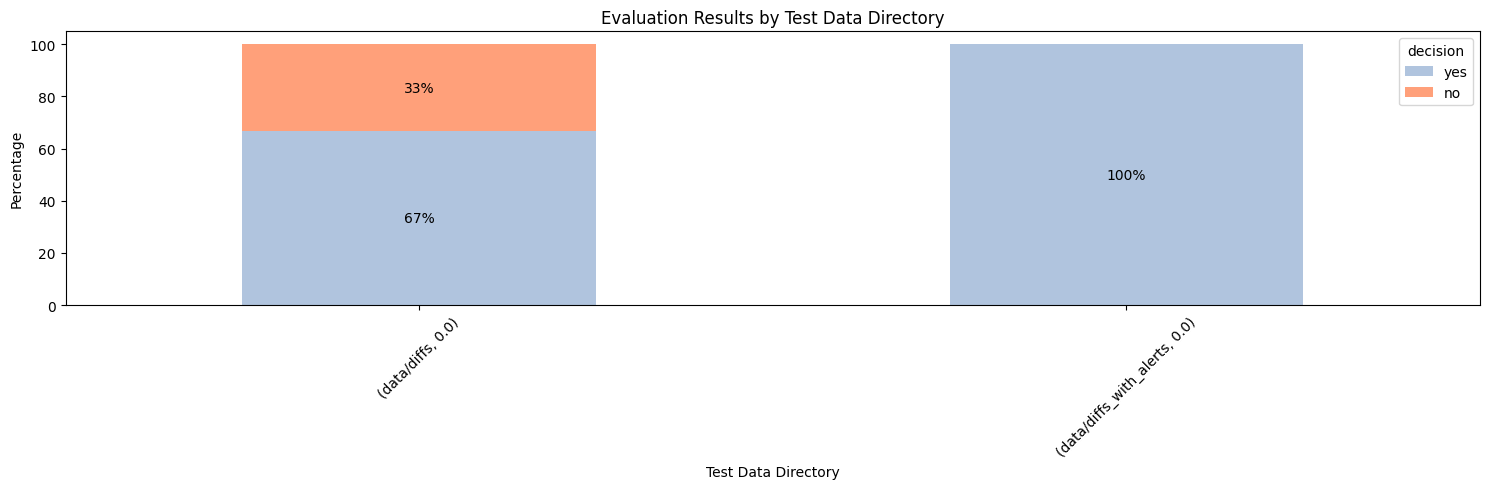

In [74]:
def create_directory():
    now = datetime.datetime.now()
    filename = now.strftime("%Y-%m-%d_%H-%M-%S")
    directory = f"data/output/{filename}"
    os.makedirs(directory, exist_ok=True)
    return directory, filename

def calculate_percentages(df):
    counts = df.groupby(['directory', 'temperature', 'decision']).size().unstack()
    counts = counts[['yes', 'no']]
    percentages = counts.div(counts.sum(axis=1), axis=0) * 100
    return percentages

def plot_percentages(percentages, filename):
    color_map = {'yes': 'lightsteelblue', 'no': 'lightsalmon'}
    fig, ax = plt.subplots(figsize=(15, 5))
    ax = percentages.plot(kind='bar', stacked=True, color=[color_map[col] for col in percentages.columns], ax=ax)
    ax.set_xlabel('Test Data Directory')
    ax.set_ylabel('Percentage')
    ax.set_title('Evaluation Results by Test Data Directory')
    plt.xticks(rotation=45)
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        if height > 0:
            ax.annotate(f'{height:.0f}%', (x + width/2, y + height/2), ha='center', va='center')
    plt.tight_layout()
    plt.savefig(f"data/output/{filename}/plot.png")
    plt.show()

def filter_decisions(df):
    df_no = df[(df['decision'] == 'no') & (df['directory'].str.contains('alerts_with_findings'))]
    return df_no

def top_token_usage(df):
    df_token = df[['tokens', 'directory', 'file', 'model', 'decision', 'reason']]
    df_token_sorted = df_token.sort_values('tokens', ascending=False)
    df_token_top10 = df_token_sorted.head(10)
    return df_token_top10

def write_to_csv(df, filename):
    df.to_csv(f"data/output/{filename}/export.csv",index=False)

def write_to_md(df_no, df_token_top10, directory, prompt):
    with open(f"{directory}/report.md", 'w') as f:
        f.write(f"# Smart-scan Analysis Results\n\n![Plot](plot.png)\n")
        f.write(f"\n[Link to full CSV export](export.csv)\n")
        f.write(f"## Test Parameters\n")
        f.write(f"#### Models:\n{models}\n")
        f.write(f"#### Temperatures:\n{temperatures}\n")
        f.write(f"#### Prompt:\n{prompt}\n")
        f.write(f"\n## \"No\" Decision\n\n")
        f.write(f"{df_no[['directory', 'file', 'model', 'decision', 'reason']].to_markdown(index=False)}")
        f.write(f"\n## Top 10 Token Usage\n\n")
        f.write(df_token_top10.to_markdown(index=False))

# Use the functions
directory, filename = create_directory()
percentages = calculate_percentages(df)
plot_percentages(percentages, filename)
df_no = filter_decisions(df)
df_token_top10 = top_token_usage(df)
write_to_csv(df, filename)
write_to_md(df_no, df_token_top10, directory, prompt)

